In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Activation, Flatten, Reshape

In [2]:
X = np.load('X.npy')
X

array([[[[0.99722624],
         [0.9971899 ],
         [0.9971769 ],
         ...,
         [0.9973763 ],
         [0.99741197],
         [0.997457  ]],

        [[0.99722314],
         [0.9971881 ],
         [0.9971703 ],
         ...,
         [0.9972842 ],
         [0.99733603],
         [0.997448  ]],

        [[0.99722123],
         [0.9971895 ],
         [0.9971703 ],
         ...,
         [0.9972819 ],
         [0.99731964],
         [0.9974307 ]],

        ...,

        [[0.99758226],
         [0.99756277],
         [0.9975472 ],
         ...,
         [0.99870205],
         [0.9987449 ],
         [0.9986992 ]],

        [[0.9976113 ],
         [0.9975876 ],
         [0.9975635 ],
         ...,
         [0.9987189 ],
         [0.9987565 ],
         [0.9987826 ]],

        [[0.9976301 ],
         [0.99761593],
         [0.99759346],
         ...,
         [0.9986732 ],
         [0.99873424],
         [0.9987882 ]]],


       [[[0.9972736 ],
         [0.9972496 ],
         [0.99

In [3]:
Y = np.load('Y.npy')
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [5]:
img_size = X_train.shape[1]
print("Image Shape :", img_size)
channel_size = X_train.shape[3]
print("Channel Size :", channel_size)

Image Shape : 64
Channel Size : 1


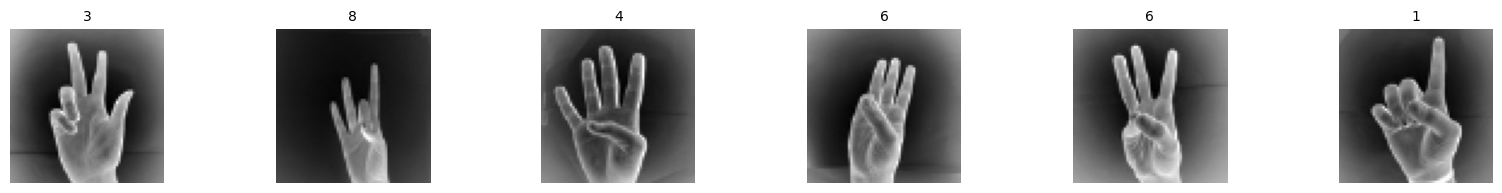

In [6]:
n = 6
plt.figure(figsize = (20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    random_index = np.random.randint(0, X_train.shape[0], 1)[0]
    plt.imshow(X_train[random_index].reshape(img_size, img_size), cmap='gray')
    ax.set_title(np.argmax(Y_train[random_index]), fontsize=10)
    plt.axis('off')

In [7]:
input_noise = Input(shape=(100,))

G_fc = Dense(256)(input_noise)
G_fc = Activation('relu')(G_fc)

G_fc = Dense(8*8*256)(G_fc)
G_fc = Activation('relu')(G_fc)

G_rs = Reshape((8, 8, 256))(G_fc)

G_layer = UpSampling2D((2, 2))(G_rs)
G_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(G_layer)

G_layer = UpSampling2D((2, 2))(G_layer)
G_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(G_layer)

G_layer = UpSampling2D((2, 2))(G_layer)
G_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(G_layer)

G_output = Conv2D(channel_size, (3, 3), activation='sigmoid', padding='same')(G_layer)


generator = Model(input_noise, G_output)

print('Architecture of the Generator :')
generator.summary()

Architecture of the Generator :
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             4210688   
                                                                 
 activation_1 (Activation)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  

In [8]:
input_img = Input(shape=(img_size, img_size, channel_size))

D_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
D_layer = MaxPooling2D((2, 2))(D_layer)

D_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(D_layer)
D_layer = MaxPooling2D((2, 2))(D_layer)

D_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(D_layer)
D_layer = MaxPooling2D((2, 2))(D_layer)

D_flt = Flatten()(D_layer)

D_fc = Dense(256)(D_flt)
D_fc = Activation('relu')(D_fc)

D_fc = Dense(128)(D_fc)
D_fc = Activation('relu')(D_fc)

D_fc = Dense(1)(D_fc)
D_output = Activation('sigmoid')(D_fc)

discriminator = Model(input_img, D_output)
discriminator.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])

print('Architecture of Discriminator :')
discriminator.summary()

Architecture of Discriminator :
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)         

In [9]:
input_dcgan = Input(shape=(100,))
generated_img = generator(input_dcgan)
dcgan_output = discriminator(generated_img)

dcgan = Model(input_dcgan, dcgan_output)
dcgan.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])

print('Architecture of DCGAN :')
dcgan.summary()

Architecture of DCGAN :
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 64, 64, 1)         5196033   
                                                                 
 model_1 (Functional)        (None, 1)                 2223105   
                                                                 
Total params: 7419138 (28.30 MB)
Trainable params: 7419138 (28.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




Epoch: 1 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 933us/step - loss: 0.0811 - acc: 0.8817

DCGAN Train:


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
2062/2062 [==============================] - 8s 4ms/step - loss: 0.0010 - acc: 1.0000

Generated Examples:


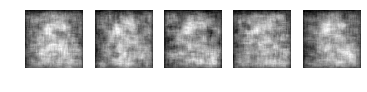



Epoch: 2 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 4.1881e-14 - acc: 1.0000

Generated Examples:


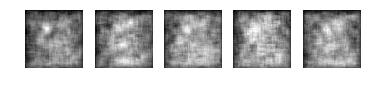



Epoch: 3 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 4.6230e-14 - acc: 1.0000

Generated Examples:


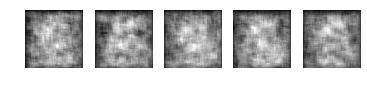



Epoch: 4 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 5.6016e-14 - acc: 1.0000

Generated Examples:


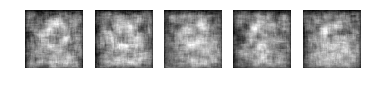



Epoch: 5 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 7.1468e-14 - acc: 1.0000

Generated Examples:


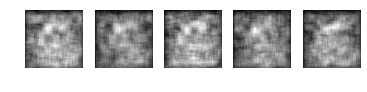



Epoch: 6 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 9.8897e-14 - acc: 1.0000

Generated Examples:


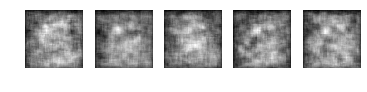



Epoch: 7 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 1.4804e-13 - acc: 1.0000

Generated Examples:


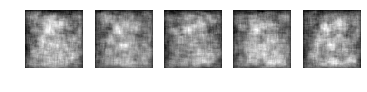



Epoch: 8 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 2.2592e-13 - acc: 1.0000

Generated Examples:


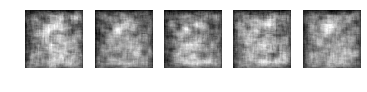



Epoch: 9 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 4.0562e-13 - acc: 1.0000

Generated Examples:


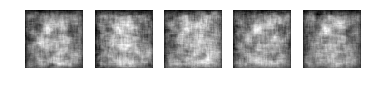



Epoch: 10 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 796us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 9.3932e-13 - acc: 1.0000

Generated Examples:


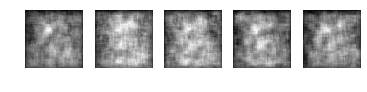



Epoch: 11 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 3.6982e-12 - acc: 1.0000

Generated Examples:


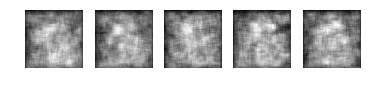



Epoch: 12 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 2.6792e-10 - acc: 1.0000

Generated Examples:


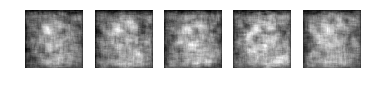



Epoch: 13 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.1300 - acc: 0.8695

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0272 - acc: 0.9690

Generated Examples:


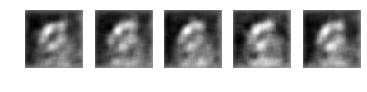



Epoch: 14 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0308 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0164 - acc: 0.9840

Generated Examples:


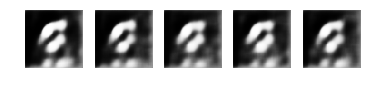



Epoch: 15 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 2.6687e-11 - acc: 1.0000

Generated Examples:


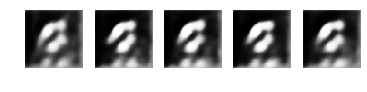



Epoch: 16 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 772us/step - loss: 0.4998 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 3.1046e-04 - acc: 1.0000

Generated Examples:


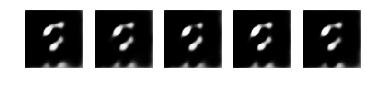



Epoch: 17 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 806us/step - loss: 0.0742 - acc: 0.9113

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


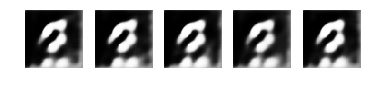



Epoch: 18 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0330 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0151 - acc: 0.9845

Generated Examples:


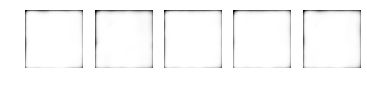



Epoch: 19 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 3.5527e-13 - acc: 1.0000

Generated Examples:


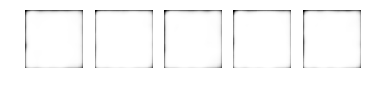



Epoch: 20 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 9.0949e-13 - acc: 1.0000

Generated Examples:


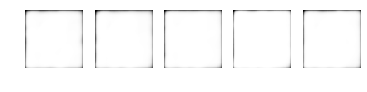



Epoch: 21 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.4609 - acc: 0.5344

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.4986 - acc: 0.4908

Generated Examples:


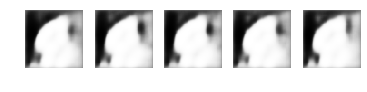



Epoch: 22 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0470 - acc: 0.9394

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


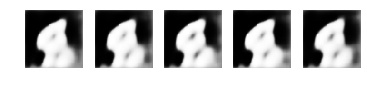



Epoch: 23 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0238 - acc: 0.9738

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


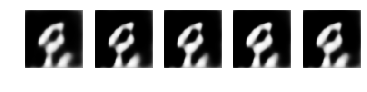



Epoch: 24 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0469 - acc: 0.9500

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0140 - acc: 0.9845

Generated Examples:


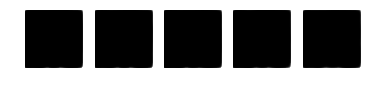



Epoch: 25 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0399 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0411 - acc: 0.9534

Generated Examples:


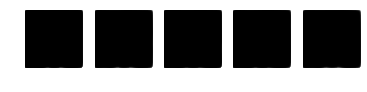



Epoch: 26 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0295 - acc: 0.9631

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0630 - acc: 0.9224

Generated Examples:


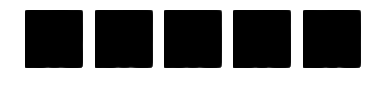



Epoch: 27 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 771us/step - loss: 0.0434 - acc: 0.9505

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0661 - acc: 0.9224

Generated Examples:


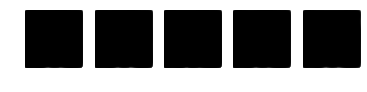



Epoch: 28 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0385 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0772 - acc: 0.9069

Generated Examples:


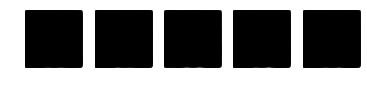



Epoch: 29 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 794us/step - loss: 0.0433 - acc: 0.9515

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0423 - acc: 0.9534

Generated Examples:


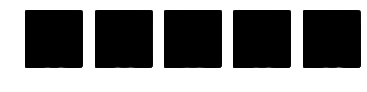



Epoch: 30 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0240 - acc: 0.9753

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0663 - acc: 0.9224

Generated Examples:


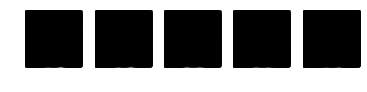



Epoch: 31 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 774us/step - loss: 0.0354 - acc: 0.9549

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0759 - acc: 0.9069

Generated Examples:


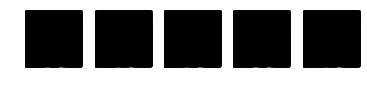



Epoch: 32 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 800us/step - loss: 0.0455 - acc: 0.9437

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0633 - acc: 0.9224

Generated Examples:


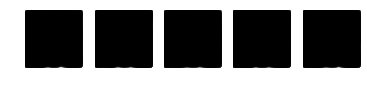



Epoch: 33 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0332 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0568 - acc: 0.9379

Generated Examples:


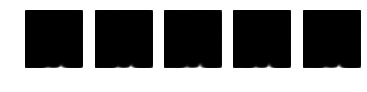



Epoch: 34 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0287 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0435 - acc: 0.9534

Generated Examples:


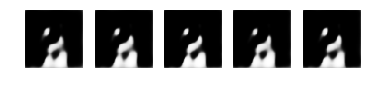



Epoch: 35 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 5.3533e-09 - acc: 1.0000

Generated Examples:


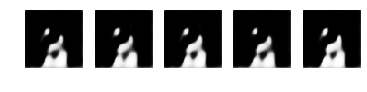



Epoch: 36 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0709 - acc: 0.9297

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0223 - acc: 0.9690

Generated Examples:


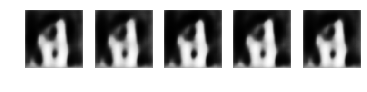



Epoch: 37 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 769us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 1.8871e-11 - acc: 1.0000

Generated Examples:


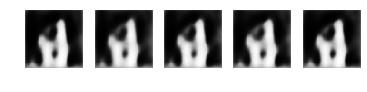



Epoch: 38 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 772us/step - loss: 0.3623 - acc: 0.6372

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0148 - acc: 0.9845

Generated Examples:


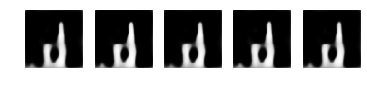



Epoch: 39 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 794us/step - loss: 0.0414 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


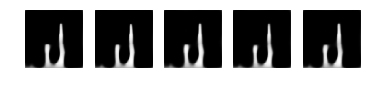



Epoch: 40 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 768us/step - loss: 0.0289 - acc: 0.9694

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0177 - acc: 0.9845

Generated Examples:


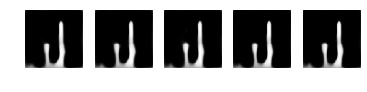



Epoch: 41 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0374 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0230 - acc: 0.9690

Generated Examples:


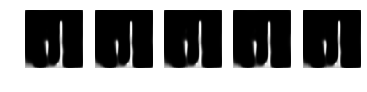



Epoch: 42 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0613 - acc: 0.9365

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0305 - acc: 0.9690

Generated Examples:


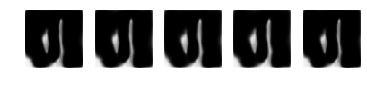



Epoch: 43 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0267 - acc: 0.9685

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0293 - acc: 0.9690

Generated Examples:


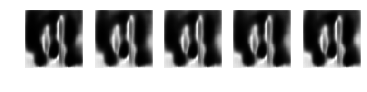



Epoch: 44 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 792us/step - loss: 0.0374 - acc: 0.9617

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0151 - acc: 0.9845

Generated Examples:


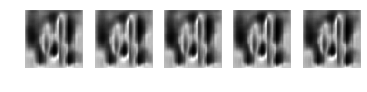



Epoch: 45 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0521 - acc: 0.9403

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


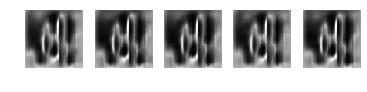



Epoch: 46 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0369 - acc: 0.9593

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


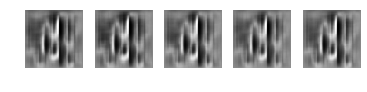



Epoch: 47 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0353 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


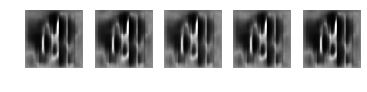



Epoch: 48 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 800us/step - loss: 0.0331 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


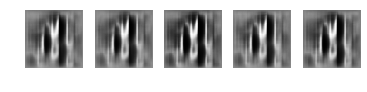



Epoch: 49 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0394 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


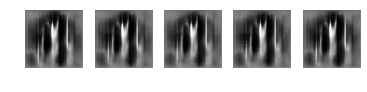



Epoch: 50 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 796us/step - loss: 0.0501 - acc: 0.9442

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


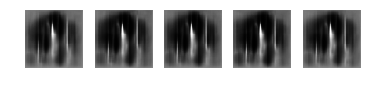



Epoch: 51 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 770us/step - loss: 0.0337 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0164 - acc: 0.9845

Generated Examples:


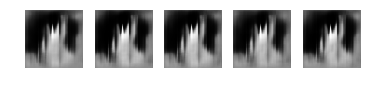



Epoch: 52 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 2.0959e-11 - acc: 1.0000

Generated Examples:


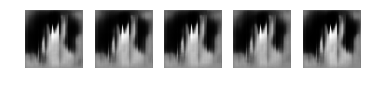



Epoch: 53 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.5000 - acc: 0.5000

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 3.3737e-10 - acc: 1.0000

Generated Examples:


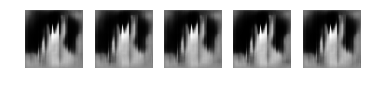



Epoch: 54 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.2115 - acc: 0.7876

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0151 - acc: 0.9845

Generated Examples:


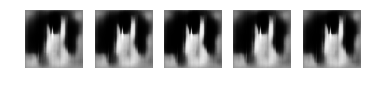



Epoch: 55 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0435 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


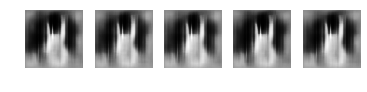



Epoch: 56 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0328 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


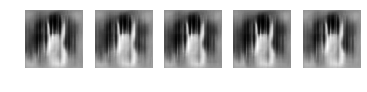



Epoch: 57 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0327 - acc: 0.9670

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


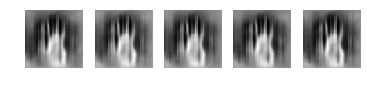



Epoch: 58 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0387 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


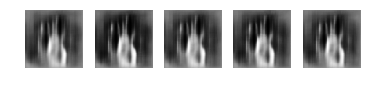



Epoch: 59 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0462 - acc: 0.9491

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0151 - acc: 0.9845

Generated Examples:


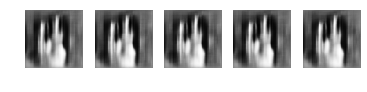



Epoch: 60 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0422 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0269 - acc: 0.9690

Generated Examples:


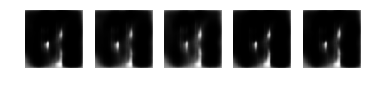



Epoch: 61 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0381 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0163 - acc: 0.9845

Generated Examples:


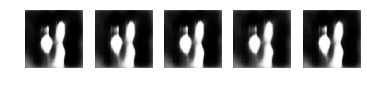



Epoch: 62 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0373 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


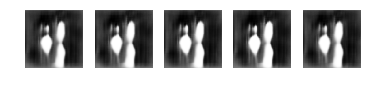



Epoch: 63 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 761us/step - loss: 0.0520 - acc: 0.9418

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


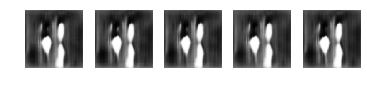



Epoch: 64 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 797us/step - loss: 0.0388 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


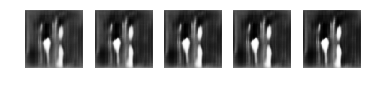



Epoch: 65 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0460 - acc: 0.9471

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


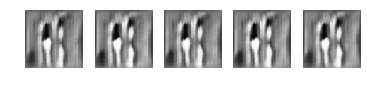



Epoch: 66 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0387 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0265 - acc: 0.9690

Generated Examples:


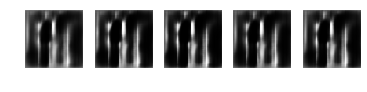



Epoch: 67 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 796us/step - loss: 0.0374 - acc: 0.9588

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0167 - acc: 0.9845

Generated Examples:


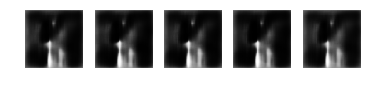



Epoch: 68 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 802us/step - loss: 0.0353 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


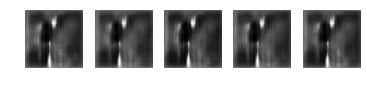



Epoch: 69 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0391 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


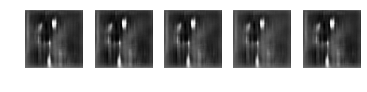



Epoch: 70 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 770us/step - loss: 0.0304 - acc: 0.9690

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


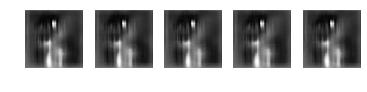



Epoch: 71 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 796us/step - loss: 0.0317 - acc: 0.9670

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


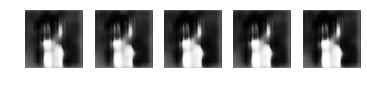



Epoch: 72 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.1377 - acc: 0.8574

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


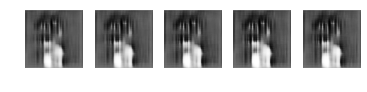



Epoch: 73 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0397 - acc: 0.9549

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


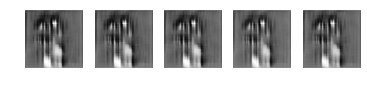



Epoch: 74 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0373 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


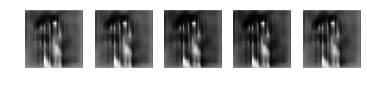



Epoch: 75 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0312 - acc: 0.9680

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


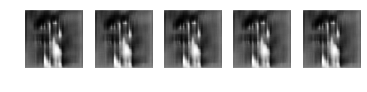



Epoch: 76 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0330 - acc: 0.9631

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


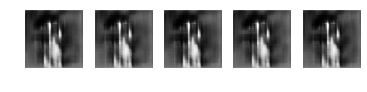



Epoch: 77 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0375 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


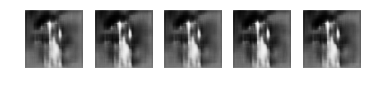



Epoch: 78 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0359 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


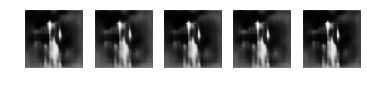



Epoch: 79 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 809us/step - loss: 0.0320 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


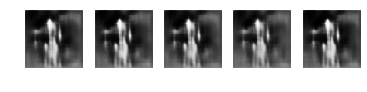



Epoch: 80 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0480 - acc: 0.9491

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


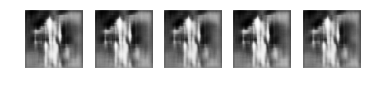



Epoch: 81 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0353 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


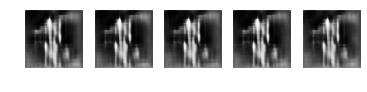



Epoch: 82 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0369 - acc: 0.9593

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


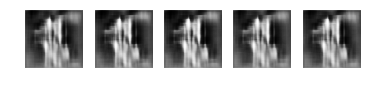



Epoch: 83 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0419 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


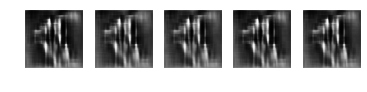



Epoch: 84 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0290 - acc: 0.9719

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


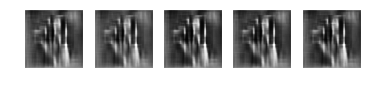



Epoch: 85 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0451 - acc: 0.9549

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


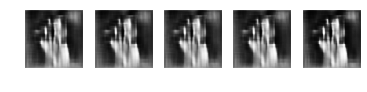



Epoch: 86 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 798us/step - loss: 0.0347 - acc: 0.9641

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


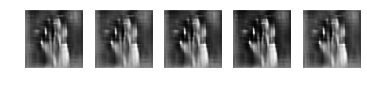



Epoch: 87 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0343 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


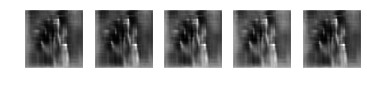



Epoch: 88 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0397 - acc: 0.9559

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


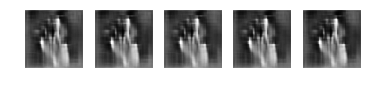



Epoch: 89 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0368 - acc: 0.9593

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


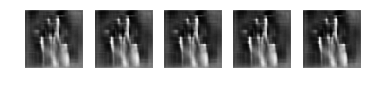



Epoch: 90 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 782us/step - loss: 0.0385 - acc: 0.9593

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


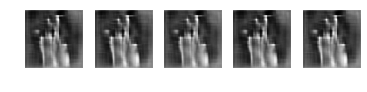



Epoch: 91 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 782us/step - loss: 0.0358 - acc: 0.9641

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0162 - acc: 0.9845

Generated Examples:


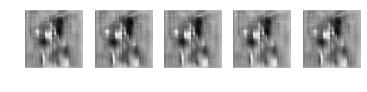



Epoch: 92 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0438 - acc: 0.9486

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


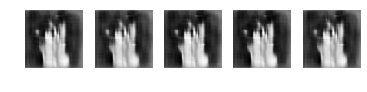



Epoch: 93 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0400 - acc: 0.9588

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


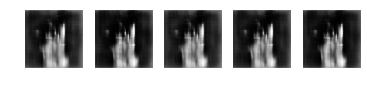



Epoch: 94 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 792us/step - loss: 0.0417 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


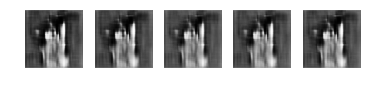



Epoch: 95 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0301 - acc: 0.9699

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


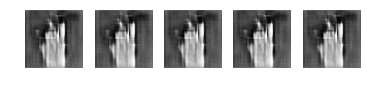



Epoch: 96 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 792us/step - loss: 0.0414 - acc: 0.9549

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0205 - acc: 0.9704

Generated Examples:


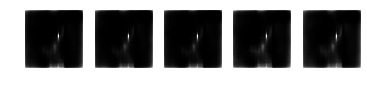



Epoch: 97 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 797us/step - loss: 0.0272 - acc: 0.9680

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0304 - acc: 0.9690

Generated Examples:


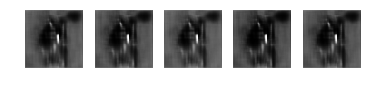



Epoch: 98 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0405 - acc: 0.9544

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


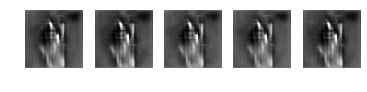



Epoch: 99 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0378 - acc: 0.9568

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


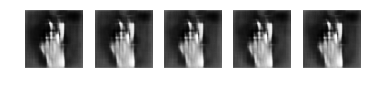



Epoch: 100 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 797us/step - loss: 0.0359 - acc: 0.9607

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


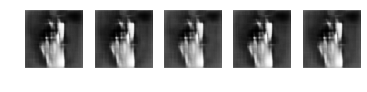



Epoch: 101 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0324 - acc: 0.9680

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


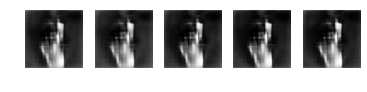



Epoch: 102 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0364 - acc: 0.9641

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


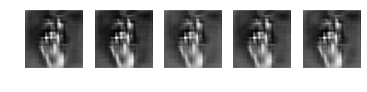



Epoch: 103 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0337 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


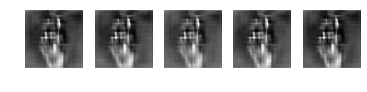



Epoch: 104 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0443 - acc: 0.9534

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


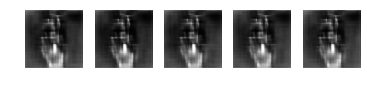



Epoch: 105 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0352 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


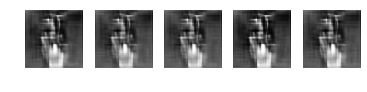



Epoch: 106 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0359 - acc: 0.9593

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


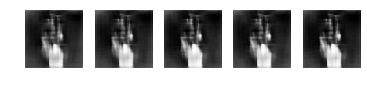



Epoch: 107 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0372 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


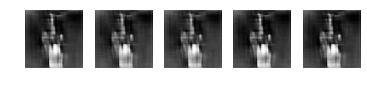



Epoch: 108 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 770us/step - loss: 0.0362 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


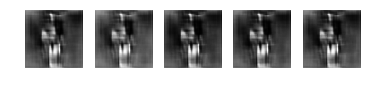



Epoch: 109 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0383 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


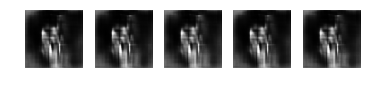



Epoch: 110 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0369 - acc: 0.9612

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


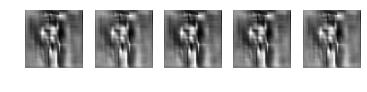



Epoch: 111 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0339 - acc: 0.9641

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0163 - acc: 0.9845

Generated Examples:


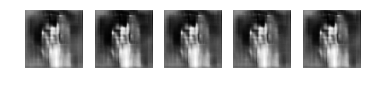



Epoch: 112 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 769us/step - loss: 0.0363 - acc: 0.9612

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


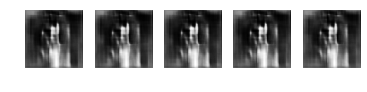



Epoch: 113 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 774us/step - loss: 0.0345 - acc: 0.9627

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


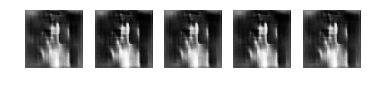



Epoch: 114 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 794us/step - loss: 0.0394 - acc: 0.9544

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


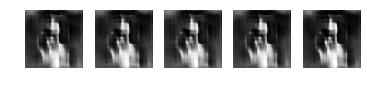



Epoch: 115 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0437 - acc: 0.9544

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


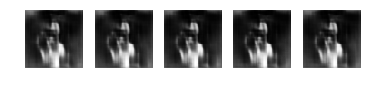



Epoch: 116 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0381 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


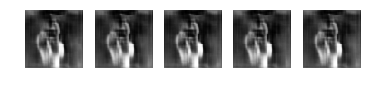



Epoch: 117 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0348 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


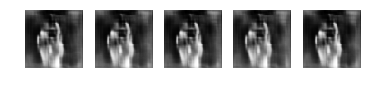



Epoch: 118 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 795us/step - loss: 0.0465 - acc: 0.9505

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


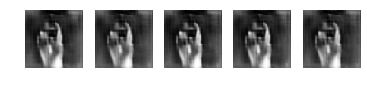



Epoch: 119 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0455 - acc: 0.9491

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


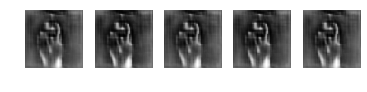



Epoch: 120 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0423 - acc: 0.9554

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0162 - acc: 0.9845

Generated Examples:


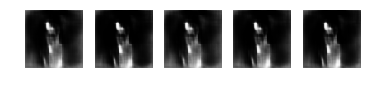



Epoch: 121 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0374 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


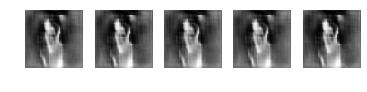



Epoch: 122 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0405 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


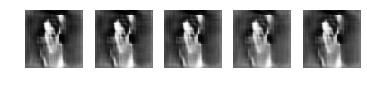



Epoch: 123 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0349 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


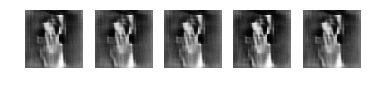



Epoch: 124 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0306 - acc: 0.9694

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


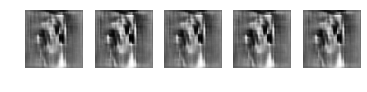



Epoch: 125 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 800us/step - loss: 0.0386 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


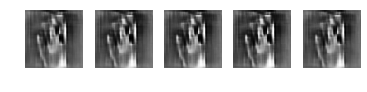



Epoch: 126 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0399 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


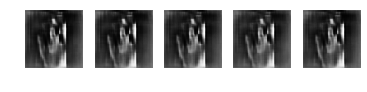



Epoch: 127 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0340 - acc: 0.9617

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


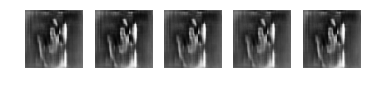



Epoch: 128 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 772us/step - loss: 0.0422 - acc: 0.9559

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


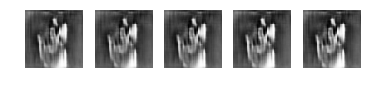



Epoch: 129 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 799us/step - loss: 0.0416 - acc: 0.9549

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


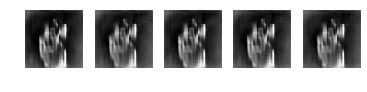



Epoch: 130 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0350 - acc: 0.9627

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


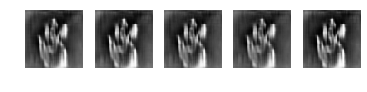



Epoch: 131 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0356 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


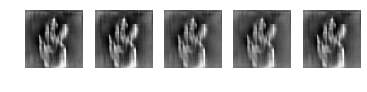



Epoch: 132 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0388 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


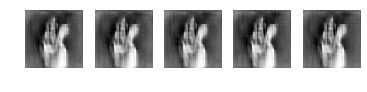



Epoch: 133 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0340 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


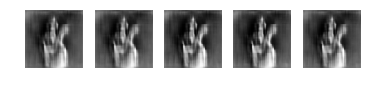



Epoch: 134 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0355 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


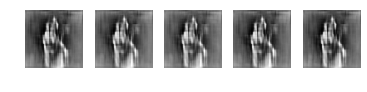



Epoch: 135 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0497 - acc: 0.9433

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


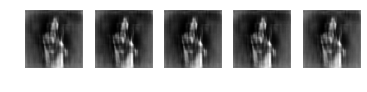



Epoch: 136 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0406 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


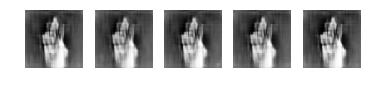



Epoch: 137 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 772us/step - loss: 0.0314 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


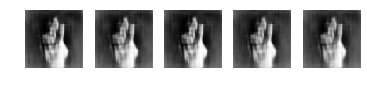



Epoch: 138 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 771us/step - loss: 0.0416 - acc: 0.9554

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


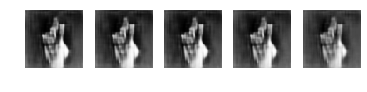



Epoch: 139 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0354 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


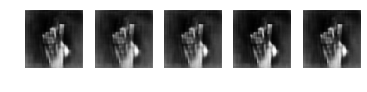



Epoch: 140 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 794us/step - loss: 0.0342 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


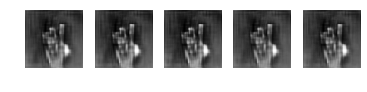



Epoch: 141 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0414 - acc: 0.9544

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


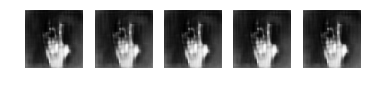



Epoch: 142 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0370 - acc: 0.9612

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


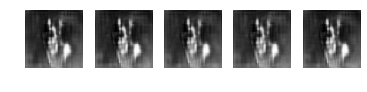



Epoch: 143 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0420 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


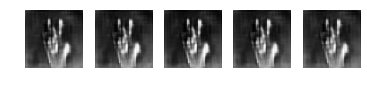



Epoch: 144 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0324 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


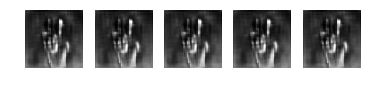



Epoch: 145 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0341 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


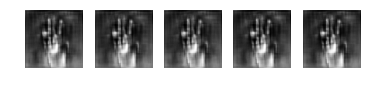



Epoch: 146 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0386 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


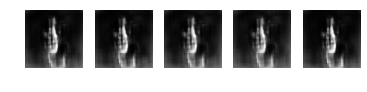



Epoch: 147 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 801us/step - loss: 0.0388 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


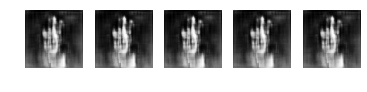



Epoch: 148 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0327 - acc: 0.9661

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


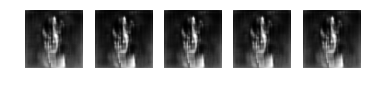



Epoch: 149 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0329 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


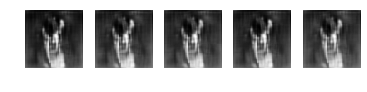



Epoch: 150 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0425 - acc: 0.9525

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


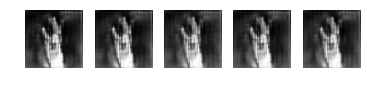



Epoch: 151 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0488 - acc: 0.9491

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


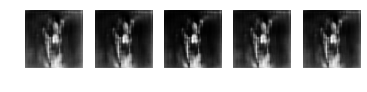



Epoch: 152 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0440 - acc: 0.9505

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


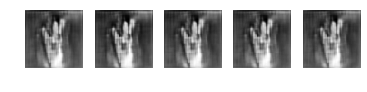



Epoch: 153 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0362 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


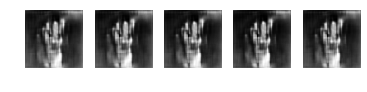



Epoch: 154 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 799us/step - loss: 0.0386 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


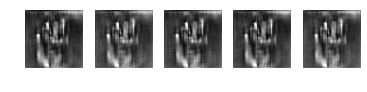



Epoch: 155 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 774us/step - loss: 0.0382 - acc: 0.9612

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


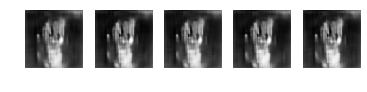



Epoch: 156 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0387 - acc: 0.9568

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


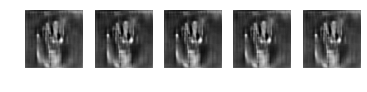



Epoch: 157 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0392 - acc: 0.9549

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


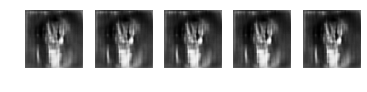



Epoch: 158 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0476 - acc: 0.9481

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0157 - acc: 0.9845

Generated Examples:


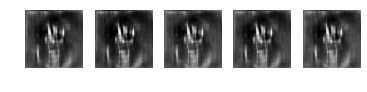



Epoch: 159 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0410 - acc: 0.9539

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0163 - acc: 0.9845

Generated Examples:


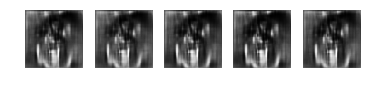



Epoch: 160 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0408 - acc: 0.9559

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0195 - acc: 0.9753

Generated Examples:


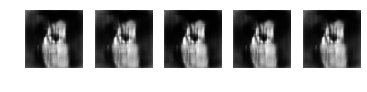



Epoch: 161 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0286 - acc: 0.9694

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0176 - acc: 0.9845

Generated Examples:


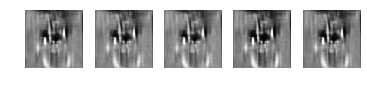



Epoch: 162 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0320 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0257 - acc: 0.9690

Generated Examples:


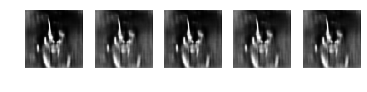



Epoch: 163 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0339 - acc: 0.9641

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0189 - acc: 0.9772

Generated Examples:


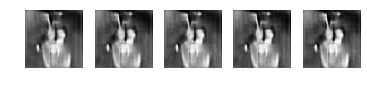



Epoch: 164 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0311 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


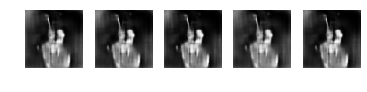



Epoch: 165 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0309 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0159 - acc: 0.9845

Generated Examples:


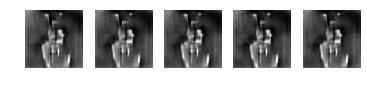



Epoch: 166 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 792us/step - loss: 0.0354 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0162 - acc: 0.9845

Generated Examples:


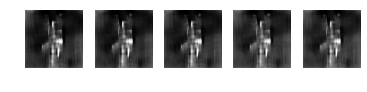



Epoch: 167 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0356 - acc: 0.9617

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


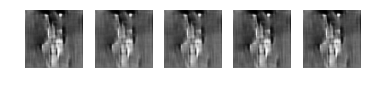



Epoch: 168 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0336 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


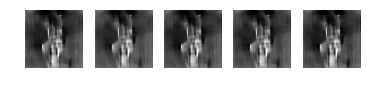



Epoch: 169 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0362 - acc: 0.9627

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0172 - acc: 0.9845

Generated Examples:


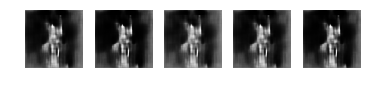



Epoch: 170 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0277 - acc: 0.9685

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0235 - acc: 0.9704

Generated Examples:


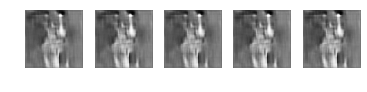



Epoch: 171 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 779us/step - loss: 0.0283 - acc: 0.9690

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0281 - acc: 0.9690

Generated Examples:


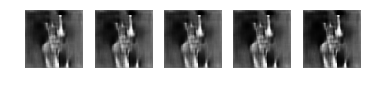



Epoch: 172 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 793us/step - loss: 0.0321 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0163 - acc: 0.9845

Generated Examples:


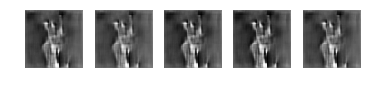



Epoch: 173 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0355 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


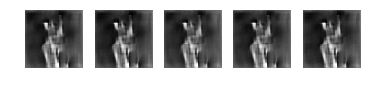



Epoch: 174 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 767us/step - loss: 0.0335 - acc: 0.9631

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


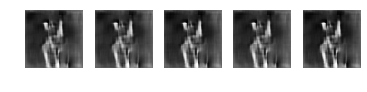



Epoch: 175 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0335 - acc: 0.9593

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


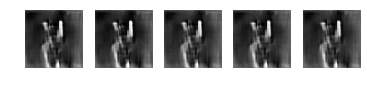



Epoch: 176 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0475 - acc: 0.9496

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0163 - acc: 0.9845

Generated Examples:


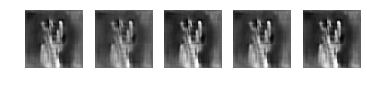



Epoch: 177 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0474 - acc: 0.9437

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


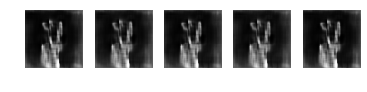



Epoch: 178 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0325 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0161 - acc: 0.9845

Generated Examples:


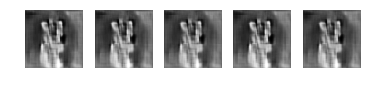



Epoch: 179 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 772us/step - loss: 0.0367 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


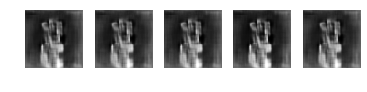



Epoch: 180 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0395 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


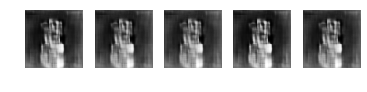



Epoch: 181 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 770us/step - loss: 0.0412 - acc: 0.9520

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


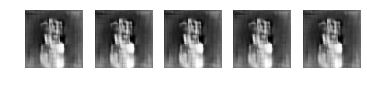



Epoch: 182 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0387 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


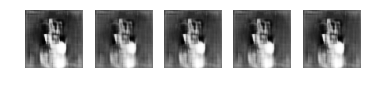



Epoch: 183 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0507 - acc: 0.9471

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


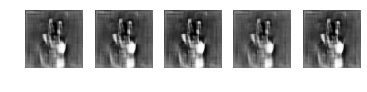



Epoch: 184 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0440 - acc: 0.9530

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


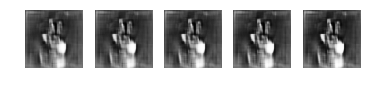



Epoch: 185 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0328 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0161 - acc: 0.9845

Generated Examples:


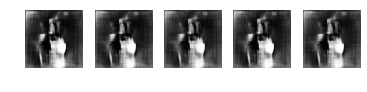



Epoch: 186 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0439 - acc: 0.9530

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0242 - acc: 0.9690

Generated Examples:


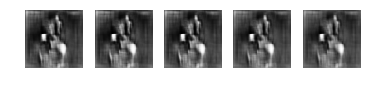



Epoch: 187 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0296 - acc: 0.9665

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0165 - acc: 0.9845

Generated Examples:


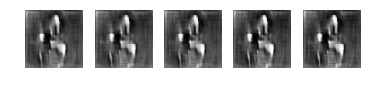



Epoch: 188 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0318 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0159 - acc: 0.9845

Generated Examples:


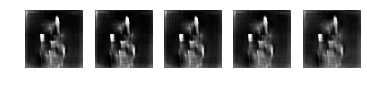



Epoch: 189 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0287 - acc: 0.9704

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0178 - acc: 0.9821

Generated Examples:


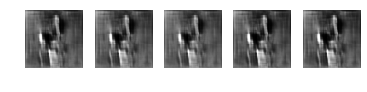



Epoch: 190 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0322 - acc: 0.9617

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0275 - acc: 0.9690

Generated Examples:


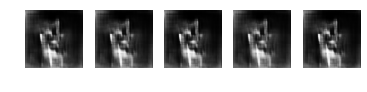



Epoch: 191 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0372 - acc: 0.9564

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


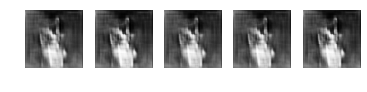



Epoch: 192 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 770us/step - loss: 0.0404 - acc: 0.9544

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


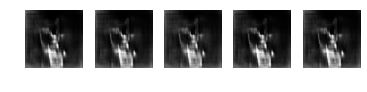



Epoch: 193 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0394 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


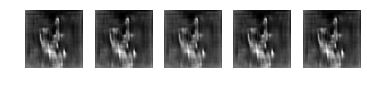



Epoch: 194 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 795us/step - loss: 0.0358 - acc: 0.9597

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


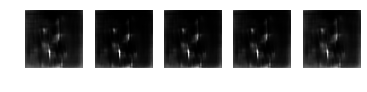



Epoch: 195 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 769us/step - loss: 0.0364 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0167 - acc: 0.9845

Generated Examples:


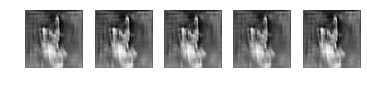



Epoch: 196 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0305 - acc: 0.9690

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0168 - acc: 0.9845

Generated Examples:


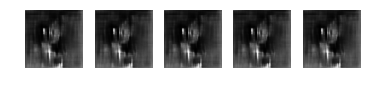



Epoch: 197 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0388 - acc: 0.9588

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0227 - acc: 0.9699

Generated Examples:


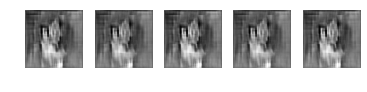



Epoch: 198 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0300 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0231 - acc: 0.9704

Generated Examples:


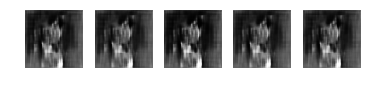



Epoch: 199 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0303 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0247 - acc: 0.9690

Generated Examples:


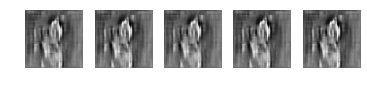



Epoch: 200 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 773us/step - loss: 0.0266 - acc: 0.9709

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0174 - acc: 0.9835

Generated Examples:


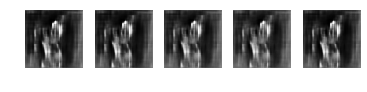



Epoch: 201 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0305 - acc: 0.9665

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0159 - acc: 0.9845

Generated Examples:


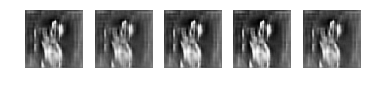



Epoch: 202 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0313 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


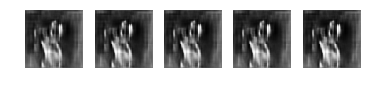



Epoch: 203 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0378 - acc: 0.9568

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0157 - acc: 0.9845

Generated Examples:


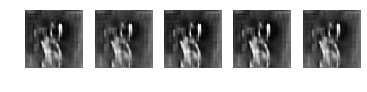



Epoch: 204 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0380 - acc: 0.9588

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0167 - acc: 0.9845

Generated Examples:


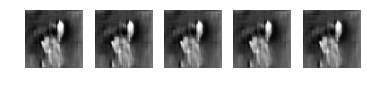



Epoch: 205 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 794us/step - loss: 0.0384 - acc: 0.9588

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0170 - acc: 0.9845

Generated Examples:


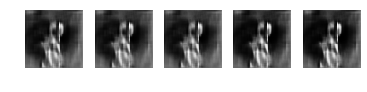



Epoch: 206 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 771us/step - loss: 0.0316 - acc: 0.9661

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0291 - acc: 0.9690

Generated Examples:


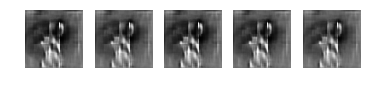



Epoch: 207 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 782us/step - loss: 0.0263 - acc: 0.9709

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0173 - acc: 0.9845

Generated Examples:


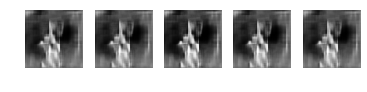



Epoch: 208 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0297 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0189 - acc: 0.9782

Generated Examples:


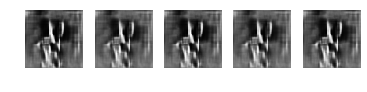



Epoch: 209 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0313 - acc: 0.9685

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0262 - acc: 0.9690

Generated Examples:


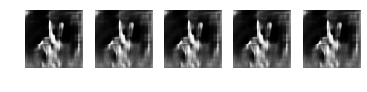



Epoch: 210 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 784us/step - loss: 0.0209 - acc: 0.9748

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0297 - acc: 0.9690

Generated Examples:


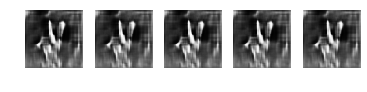



Epoch: 211 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 778us/step - loss: 0.0252 - acc: 0.9762

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0243 - acc: 0.9690

Generated Examples:


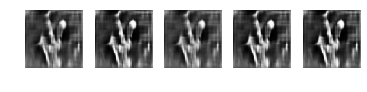



Epoch: 212 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 796us/step - loss: 0.0281 - acc: 0.9714

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0248 - acc: 0.9690

Generated Examples:


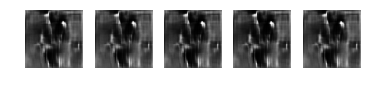



Epoch: 213 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 796us/step - loss: 0.0303 - acc: 0.9690

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0291 - acc: 0.9690

Generated Examples:


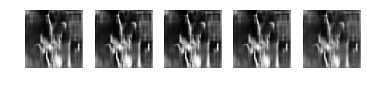



Epoch: 214 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0268 - acc: 0.9680

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0250 - acc: 0.9690

Generated Examples:


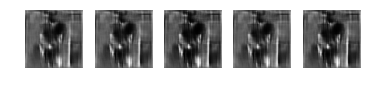



Epoch: 215 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0270 - acc: 0.9719

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0272 - acc: 0.9690

Generated Examples:


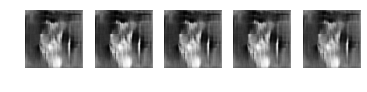



Epoch: 216 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 793us/step - loss: 0.0317 - acc: 0.9661

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0231 - acc: 0.9699

Generated Examples:


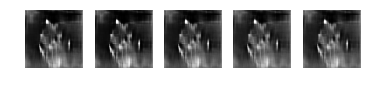



Epoch: 217 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 767us/step - loss: 0.0505 - acc: 0.9496

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0286 - acc: 0.9690

Generated Examples:


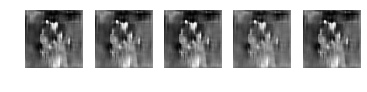



Epoch: 218 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 771us/step - loss: 0.0300 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0180 - acc: 0.9845

Generated Examples:


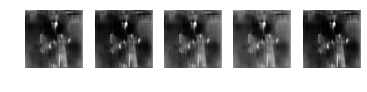



Epoch: 219 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 803us/step - loss: 0.0496 - acc: 0.9491

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0157 - acc: 0.9845

Generated Examples:


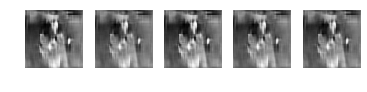



Epoch: 220 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0354 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


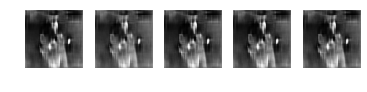



Epoch: 221 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 789us/step - loss: 0.0351 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0164 - acc: 0.9845

Generated Examples:


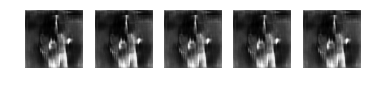



Epoch: 222 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 774us/step - loss: 0.0359 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0150 - acc: 0.9845

Generated Examples:


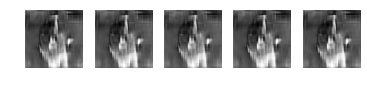



Epoch: 223 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0300 - acc: 0.9690

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0159 - acc: 0.9845

Generated Examples:


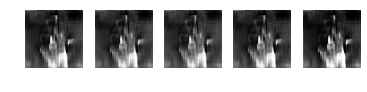



Epoch: 224 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 772us/step - loss: 0.0587 - acc: 0.9418

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0157 - acc: 0.9845

Generated Examples:


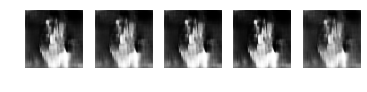



Epoch: 225 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0568 - acc: 0.9418

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


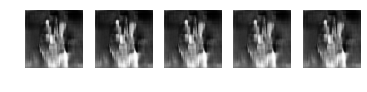



Epoch: 226 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 795us/step - loss: 0.0308 - acc: 0.9680

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


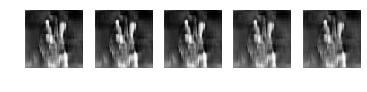



Epoch: 227 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0288 - acc: 0.9714

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


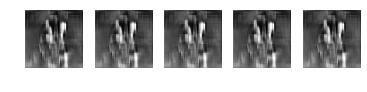



Epoch: 228 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0371 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


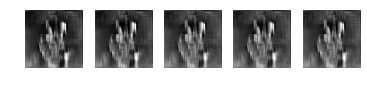



Epoch: 229 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0351 - acc: 0.9607

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


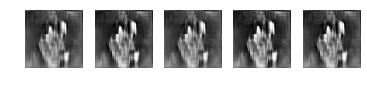



Epoch: 230 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0481 - acc: 0.9491

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


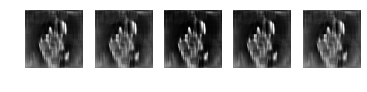



Epoch: 231 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 799us/step - loss: 0.0326 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


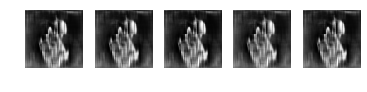



Epoch: 232 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0344 - acc: 0.9631

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


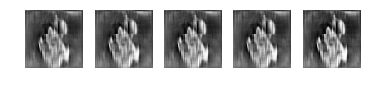



Epoch: 233 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 768us/step - loss: 0.0312 - acc: 0.9661

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


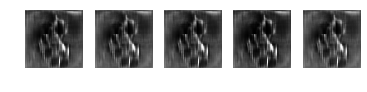



Epoch: 234 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 807us/step - loss: 0.0391 - acc: 0.9602

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


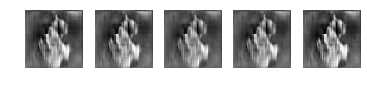



Epoch: 235 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 776us/step - loss: 0.0320 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


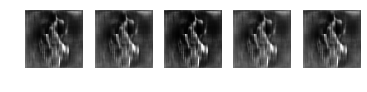



Epoch: 236 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 771us/step - loss: 0.0314 - acc: 0.9670

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


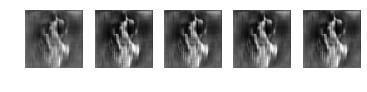



Epoch: 237 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0321 - acc: 0.9646

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0165 - acc: 0.9845

Generated Examples:


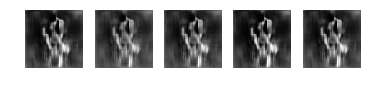



Epoch: 238 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 791us/step - loss: 0.0396 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


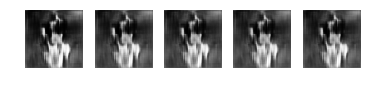



Epoch: 239 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 782us/step - loss: 0.0412 - acc: 0.9588

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


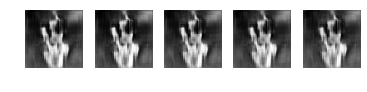



Epoch: 240 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0312 - acc: 0.9694

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


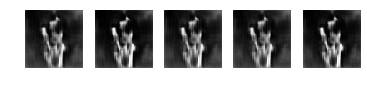



Epoch: 241 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 797us/step - loss: 0.0325 - acc: 0.9675

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0156 - acc: 0.9845

Generated Examples:


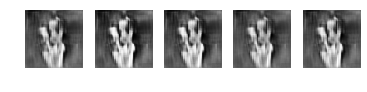



Epoch: 242 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0419 - acc: 0.9559

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0152 - acc: 0.9845

Generated Examples:


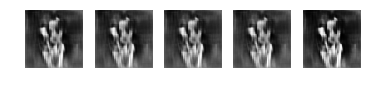



Epoch: 243 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0338 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


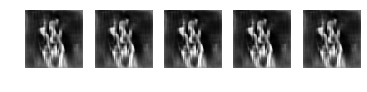



Epoch: 244 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 774us/step - loss: 0.0334 - acc: 0.9656

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0157 - acc: 0.9845

Generated Examples:


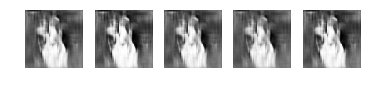



Epoch: 245 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 787us/step - loss: 0.0386 - acc: 0.9578

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


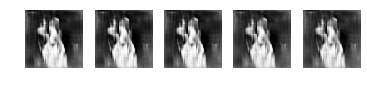



Epoch: 246 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 780us/step - loss: 0.0308 - acc: 0.9651

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0155 - acc: 0.9845

Generated Examples:


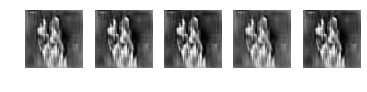



Epoch: 247 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0455 - acc: 0.9539

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9845

Generated Examples:


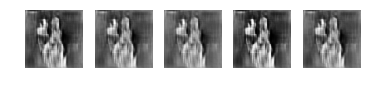



Epoch: 248 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 788us/step - loss: 0.0544 - acc: 0.9447

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0154 - acc: 0.9845

Generated Examples:


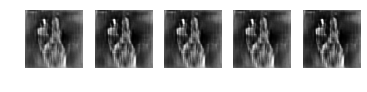



Epoch: 249 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 785us/step - loss: 0.0371 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0180 - acc: 0.9845

Generated Examples:


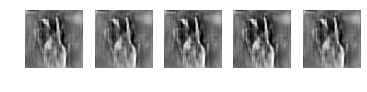



Epoch: 250 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 790us/step - loss: 0.0654 - acc: 0.9292

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0153 - acc: 0.9845

Generated Examples:


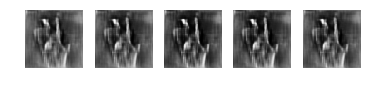



Epoch: 251 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 777us/step - loss: 0.0330 - acc: 0.9636

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0172 - acc: 0.9845

Generated Examples:


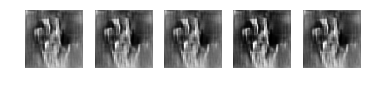



Epoch: 252 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 794us/step - loss: 0.0604 - acc: 0.9389

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0160 - acc: 0.9845

Generated Examples:


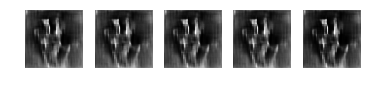



Epoch: 253 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0339 - acc: 0.9622

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0222 - acc: 0.9719

Generated Examples:


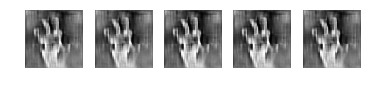



Epoch: 254 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 783us/step - loss: 0.0251 - acc: 0.9748

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0159 - acc: 0.9845

Generated Examples:


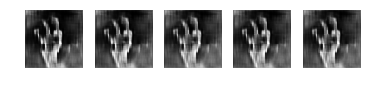



Epoch: 255 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 782us/step - loss: 0.0397 - acc: 0.9573

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0212 - acc: 0.9709

Generated Examples:


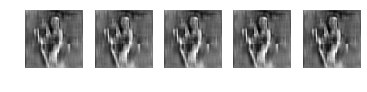



Epoch: 256 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0363 - acc: 0.9583

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0158 - acc: 0.9840

Generated Examples:


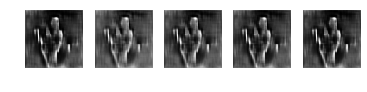



Epoch: 257 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 786us/step - loss: 0.0358 - acc: 0.9607

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0172 - acc: 0.9845

Generated Examples:


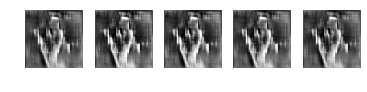



Epoch: 258 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0343 - acc: 0.9641

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0193 - acc: 0.9777

Generated Examples:


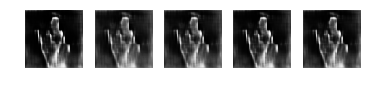



Epoch: 259 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 781us/step - loss: 0.0262 - acc: 0.9728

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0281 - acc: 0.9690

Generated Examples:


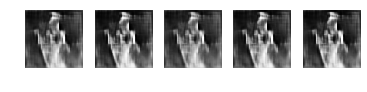



Epoch: 260 / 260

Discriminator Train:
Epoch 1/1
2062/2062 [==============================] - 2s 775us/step - loss: 0.0265 - acc: 0.9743

DCGAN Train:
Epoch 1/1
2062/2062 [==============================] - 7s 3ms/step - loss: 0.0241 - acc: 0.9690

Generated Examples:


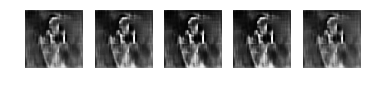

In [8]:
epochs = 260
train_data_size = int(X_train.shape[0]/2)

for epoch in range(epochs):

    print('\nEpoch :', epoch + 1, '/', epochs)

    real_imgs_indexes = np.random.randint(0, X_train.shape[0], train_data_size)
    real_imgs = X_train[real_imgs_indexes]

    noise = np.random.normal(0, 1, (train_data_size, 100))
    generator_imgs = generator.predict(noise)

    dis_batch = np.concatenate((real_imgs, generator_imgs), axis=0)
    dis_batch_Y = np.concatenate((np.ones((train_data_size, 1)), np.zeros((train_data_size, 1))), axis=0)

    discriminator.trainable = True
    print('Discriminator Train:')
    discriminator.fit(dis_batch, dis_batch_Y, batch_size=32, epochs=1, shuffle=True)


    noise = np.random.normal(0, 1, (train_data_size*2, 100))

    gen_batch_Y = np.ones((train_data_size*2, 1))

    discriminator.trainable = False
    print('DCGAN Train:')
    dcgan.fit(noise, gen_batch_Y, batch_size=32, epochs=1, shuffle=True)

    print('Generated Examples:')
    n = 5
    plt.figure(figsize=(6, 4))
    for i in range(1, n + 1):
        ax = plt.subplot(1, n, i)
        noise = np.random.normal(0, 1, (1, 100))
        plt.imshow(generator.predict(noise).reshape(img_size, img_size))
        plt.gray()
        plt.axis('off')
    plt.show()